In [18]:
import torch
import os
from torchmetrics.wrappers import MultioutputWrapper
import torchmetrics
from copy import deepcopy
import numpy as np
from qtaim_embed.models.utils import load_graph_level_model_from_config
from qtaim_embed.utils.tests import get_dataset_graph_level
from qtaim_embed.data.dataloader import DataLoaderMoleculeGraphTask
from qtaim_embed.utils.data import get_default_graph_level_config
from qtaim_embed.core.dataset import HeteroGraphGraphLabelDataset
from qtaim_embed.models.utils import get_test_train_preds_as_df, test_and_predict_libe
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
import pytorch_lightning as pl


In [19]:
feat_dict_large = {
    "atom": [
        "extra_feat_atom_Lagrangian_K",
        "extra_feat_atom_Hamiltonian_K",
        "extra_feat_atom_e_density",
        "extra_feat_atom_lap_e_density",
        "extra_feat_atom_e_loc_func",
        "extra_feat_atom_ave_loc_ion_E",
        "extra_feat_atom_delta_g_promolecular",
        "extra_feat_atom_delta_g_hirsh",
        "extra_feat_atom_esp_nuc",
        "extra_feat_atom_esp_e",
        "extra_feat_atom_esp_total",
        "extra_feat_atom_grad_norm",
        "extra_feat_atom_lap_norm",
        "extra_feat_atom_eig_hess",
        "extra_feat_atom_det_hessian",
        "extra_feat_atom_ellip_e_dens",
        "extra_feat_atom_eta",
        "extra_feat_atom_energy_density",
        "extra_feat_atom_density_beta",
        "extra_feat_atom_density_alpha",
        "extra_feat_atom_spin_density",
        "extra_feat_atom_lol",
    ],
    "bond": [
        "bond_length",
        "extra_feat_bond_Lagrangian_K",
        "extra_feat_bond_Hamiltonian_K",
        "extra_feat_bond_e_density",
        "extra_feat_bond_lap_e_density",
        "extra_feat_bond_e_loc_func",
        "extra_feat_bond_ave_loc_ion_E",
        "extra_feat_bond_delta_g_promolecular",
        "extra_feat_bond_delta_g_hirsh",
        "extra_feat_bond_esp_nuc",
        "extra_feat_bond_esp_e",
        "extra_feat_bond_esp_total",
        "extra_feat_bond_grad_norm",
        "extra_feat_bond_lap_norm",
        "extra_feat_bond_eig_hess",
        "extra_feat_bond_det_hessian",
        "extra_feat_bond_ellip_e_dens",
        "extra_feat_bond_eta",
        "extra_feat_bond_energy_density",
        "extra_feat_bond_density_beta",
        "extra_feat_bond_density_alpha",
        "extra_feat_bond_spin_density",
        "extra_feat_bond_lol",
    ],
    "global": ["E1-CC2", "E2-CC2"],
}

feat_dict = {
    "atom": [

    ],
    "bond": [
        "bond_length",

    ],
    "global": ["E1-CC2", "E2-CC2"],
}


In [20]:
qm8_loc = "../../../../data/splits_1205/test_qm8_qtaim_1205_labelled.pkl"
qm8_train_loc = "../../../../data/splits_1205/train_qm8_qtaim_1205_labelled.pkl"

dataset_test_qtaim_small = HeteroGraphGraphLabelDataset(
    file=qm8_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=False,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)
dataset_train_qtaim_small = HeteroGraphGraphLabelDataset(
    file=qm8_train_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=False,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)

dataset_test_qtaim_large = HeteroGraphGraphLabelDataset(
    file=qm8_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict_large,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=True,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)
dataset_train_qtaim_large = HeteroGraphGraphLabelDataset(
    file=qm8_train_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict_large,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=True,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)


... > creating MoleculeWrapper objects


100%|██████████| 2178/2178 [00:00<00:00, 13135.64it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'O', 'F', 'H', 'C', 'N'}
selected atomic keys []
selected bond keys ['bond_length']
selected global keys ['E1-CC2', 'E2-CC2']
... > Building graphs and featurizing


100%|██████████| 2178/2178 [00:03<00:00, 637.83it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_O', 'chemical_symbol_F', 'chemical_symbol_H', 'chemical_symbol_C', 'chemical_symbol_N'], 'bond': ['metal bond', 'ring inclusion', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7', 'bond_length'], 'global': ['num atoms', 'num bonds', 'molecule weight']}
original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys([])
include names:  dict_keys(['global'])
... > parsing labels and features in graphs


100%|██████████| 2178/2178 [00:00<00:00, 34810.02it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Scaling features
mean [1.41136780e+00 3.22392498e-01 4.42303294e-02 2.45882891e-02
 1.54963403e-02 3.54528820e-03 6.00411711e-04 7.88826624e-02
 2.08714547e-03 5.16239707e-01 3.41691446e-01 6.10990393e-02]
std [1.58425717 0.64424182 0.20560644 0.15486673 0.12351601 0.05943668
 0.02449594 0.26955554 0.04563759 0.4997362  0.47427671 0.23951189]
mean [0.00000000e+00 5.93265633e-02 3.29846530e-02 2.07681148e-02
 4.81026189e-03 8.01710315e-04 1.55400761e+00]
std [0.         0.23623489 0.17859638 0.14260715 0.06918904 0.02830314
 0.77251188]
Standard deviation for feature 0 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [ 16.05876951  12.02662994 108.90953267]
std [2.96664016 1.78690979 8.12662995]
... > Scaling features complete
... > feature mean(s): 
 {'atom': tensor([1.4114e+00, 3.2239e-01, 4.4230e-02, 2.4588e-02, 1.5496e-02, 3.5453e-03,
     

100%|██████████| 19607/19607 [00:01<00:00, 12787.90it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'O', 'F', 'H', 'C', 'N'}
selected atomic keys []
selected bond keys ['bond_length']
selected global keys ['E1-CC2', 'E2-CC2']
... > Building graphs and featurizing


100%|██████████| 19607/19607 [00:31<00:00, 620.70it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_O', 'chemical_symbol_F', 'chemical_symbol_H', 'chemical_symbol_C', 'chemical_symbol_N'], 'bond': ['metal bond', 'ring inclusion', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7', 'bond_length'], 'global': ['num atoms', 'num bonds', 'molecule weight']}
original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys([])
include names:  dict_keys(['global'])
... > parsing labels and features in graphs


100%|██████████| 19607/19607 [00:00<00:00, 34828.56it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Scaling features
mean [1.40693510e+00 3.21409331e-01 4.34981018e-02 2.37487086e-02
 1.50180318e-02 3.99931549e-03 7.32045862e-04 7.86172890e-02
 1.39120404e-03 5.17005013e-01 3.43693948e-01 5.92925458e-02]
std [1.5807023  0.64451751 0.20397553 0.15226525 0.12162438 0.06311356
 0.02704644 0.2691405  0.03727289 0.49971075 0.47494044 0.23617142]
mean [0.00000000e+00 5.85509116e-02 3.20213561e-02 2.01889451e-02
 5.44936000e-03 9.80375514e-04 1.55522426e+00]
std [0.         0.23478224 0.17605678 0.14064619 0.07361837 0.0312956
 0.7714357 ]
Standard deviation for feature 0 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [ 16.09394604  12.01734075 108.859255  ]
std [2.90372676 1.74248899 8.05426511]
... > Scaling features complete
... > feature mean(s): 
 {'atom': tensor([1.4069e+00, 3.2141e-01, 4.3498e-02, 2.3749e-02, 1.5018e-02, 3.9993e-03,
      

100%|██████████| 2178/2178 [00:00<00:00, 2830.92it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'O', 'F', 'H', 'C', 'N'}
selected atomic keys ['extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol']
selected bond keys ['bond_length', 'extra_feat_bond_Lagrangian_K', 'extra_feat_bond_Hamiltonian_K', 'extra_feat_bond_e_density', 'extra_feat_bond_lap_e_density', 'extra_feat_bond_e_loc_func', 'extra_feat_b

100%|██████████| 2178/2178 [00:03<00:00, 612.02it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_O', 'chemical_symbol_F', 'chemical_symbol_H', 'chemical_symbol_C', 'chemical_symbol_N', 'extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol'], 'bond': ['metal bond', 'ring inclus

100%|██████████| 2178/2178 [00:00<00:00, 34006.35it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Log scaling features
... > Log scaling features complete
... > Scaling features
mean [ 6.96288349e-01  1.98805120e-01  3.06581282e-02  1.70433033e-02
  1.07412447e-02  2.45740653e-03  4.16173686e-04  5.46772952e-02
  1.44669900e-03  3.57830099e-01  2.36842463e-01  4.23506270e-02
  1.33237674e+00  7.20769773e+00 -7.20769773e+00 -8.53820256e+00
  6.93094667e-01  1.42924123e+00  7.98841510e-02  1.27265091e-01
  9.14609075e+00 -3.00812352e+00  8.97849822e+00  0.00000000e+00
 -8.53820256e+00 -8.53820256e+00 -2.22587121e+01  3.32730471e-04
 -7.17489789e-01 -7.20769773e+00  2.20061768e+00  2.20061768e+00
  0.00000000e+00  6.89756672e-01]
std [5.93877267e-01 3.66309583e-01 1.42515523e-01 1.07345440e-01
 8.56147717e-02 4.11983684e-02 1.69792938e-02 1.86841662e-01
 3.16335644e-02 3.46390741e-01 3.28743568e-01 1.66016994e-01
 1.47758331e+00 5.39269696e+00 5.39269696e+00 5.446

100%|██████████| 19607/19607 [00:07<00:00, 2686.18it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'O', 'F', 'H', 'C', 'N'}
selected atomic keys ['extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol']
selected bond keys ['bond_length', 'extra_feat_bond_Lagrangian_K', 'extra_feat_bond_Hamiltonian_K', 'extra_feat_bond_e_density', 'extra_feat_bond_lap_e_density', 'extra_feat_bond_e_loc_func', 'extra_feat_b

100%|██████████| 19607/19607 [00:32<00:00, 605.10it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_O', 'chemical_symbol_F', 'chemical_symbol_H', 'chemical_symbol_C', 'chemical_symbol_N', 'extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol'], 'bond': ['metal bond', 'ring inclus

100%|██████████| 19607/19607 [00:00<00:00, 33867.53it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Log scaling features
... > Log scaling features complete
... > Scaling features
mean [ 6.94480210e-01  1.98050807e-01  3.01505867e-02  1.64613505e-02
  1.04097064e-02  2.77211426e-03  5.07415527e-04  5.44933523e-02
  9.64309161e-04  3.58360568e-01  2.38230492e-01  4.10984611e-02
  1.32616490e+00  7.19627663e+00 -7.19627663e+00 -8.52669674e+00
  6.93095289e-01  1.42630408e+00  7.98208921e-02  1.27152467e-01
  9.14825234e+00 -3.00580327e+00  8.98075974e+00  0.00000000e+00
 -8.52669674e+00 -8.52669674e+00 -2.22241076e+01  3.32077713e-04
 -7.17475531e-01 -7.19627663e+00  2.19560489e+00  2.19560489e+00
  0.00000000e+00  6.89766178e-01]
std [5.93734382e-01 3.66119205e-01 1.41385064e-01 1.05542232e-01
 8.43035983e-02 4.37469836e-02 1.87471644e-02 1.86553982e-01
 2.58356011e-02 3.46373096e-01 3.29203625e-01 1.63701555e-01
 1.47188583e+00 5.38900363e+00 5.38900363e+00 5.442

In [5]:
"""best_model_qtaim = {
    "atom_feature_size": 34,
    "bond_feature_size": 29,
    "global_feature_size": 3,
    "conv_fn": "ResidualBlock",
    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},
    "dropout": 0.2,
    "batch_norm_tf": False,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 4,
    "lr": 0.044675426899321025,
    "weight_decay": 0.000005,
    "lr_plateau_patience": 10,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 80,
    "fc_layer_size": [512, 512],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 2,
    "global_pooling_fn": "MeanPoolingThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 3,
    "feat_drop": 0.2,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 64,
    "ntasks": 2,
    "num_heads_gat": 1,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 8,
    "residual_gat": True,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "shape_fc": "flat",
    "restore": False,
    "classifier": False,
    "fc_hidden_size_1": 512,
    "fc_num_layers": 3,
}"""


'best_model_qtaim = {\n    "atom_feature_size": 34,\n    "bond_feature_size": 29,\n    "global_feature_size": 3,\n    "conv_fn": "ResidualBlock",\n    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},\n    "dropout": 0.2,\n    "batch_norm_tf": False,\n    "activation": "ReLU",\n    "bias": True,\n    "norm": "both",\n    "aggregate": "sum",\n    "n_conv_layers": 4,\n    "lr": 0.044675426899321025,\n    "weight_decay": 0.000005,\n    "lr_plateau_patience": 10,\n    "lr_scale_factor": 0.5,\n    "scheduler_name": "reduce_on_plateau",\n    "loss_fn": "mse",\n    "resid_n_graph_convs": 2,\n    "embedding_size": 80,\n    "fc_layer_size": [512, 512],\n    "fc_dropout": 0.1,\n    "fc_batch_norm": True,\n    "n_fc_layers": 2,\n    "global_pooling_fn": "MeanPoolingThenCat",\n    "ntypes_pool": ["atom", "bond", "global"],\n    "ntypes_pool_direct_cat": ["global"],\n    "lstm_iters": 15,\n    "lstm_layers": 2,\n    "num_heads": 3,\n    "feat_drop": 0.2,\n    "attn_drop": 0.1,\n    "residual": False

In [62]:
best_model_noqtaim = {
    "atom_feature_size": 12,
    "bond_feature_size": 7,
    "global_feature_size": 3,
    "conv_fn": "GraphConvDropoutBatch",
    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},
    "dropout": 0.2,
    "batch_norm_tf": True,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 3,
    "lr": 0.013564488026117531,
    "weight_decay": 1e-05,
    "lr_plateau_patience": 25,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 16,
    "fc_layer_size": [512, 512],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 2,
    "global_pooling_fn": "WeightAndSumThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 2,
    "feat_drop": 0.1,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 10,
    "ntasks": 2,
    "num_heads_gat": 2,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 10,
    "residual_gat": False,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "restore": False,
    "classifier": False,
    "shape_fc": "flat",
    "fc_hidden_size_1": 1024,
    "fc_num_layers": 3,
}

best_model_qtaim = {
    "atom_feature_size": 34,
    "bond_feature_size": 29,
    "global_feature_size": 3,
    "conv_fn": "ResidualBlock",
    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},
    "dropout": 0.2,
    "batch_norm_tf": False,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 5,
    "lr": 0.01,
    "weight_decay": 0.0001,
    "lr_plateau_patience": 10,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 80,
    "fc_layer_size": [512, 512],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 2,
    "global_pooling_fn": "MeanPoolingThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 3,
    "feat_drop": 0.2,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 64,
    "ntasks": 2,
    "num_heads_gat": 1,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 8,
    "residual_gat": True,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "shape_fc": "cone",
    "restore": False,
    "classifier": False,
    "fc_hidden_size_1": 512,
    "fc_num_layers": 2,
}



In [63]:
model_temp = load_graph_level_model_from_config(best_model_qtaim)

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_train_qtaim_large, batch_size=256, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_test_qtaim_large,
    batch_size=len(dataset_test_qtaim_large.graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=100, verbose=False, mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=10.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)


trainer.fit(model_temp, dataloader_train)
trainer.save_checkpoint(f"./qm8_manual_qtaim.ckpt")


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type               | Params
--------------------------------------------------------
0  | activation      | ReLU               | 0     
1  | embedding       | UnifySize          | 5.3 K 
2  | conv_layers     | ModuleList         | 339 K 
3  | readout         | MeanPoolingThenCat | 0     
4  | loss            | ModuleList         | 0     
5  | fc_layers       | ModuleList         | 695 K 
6  | train_r2        | MultioutputWrapper | 0     
7  | train_torch_l1  | MultioutputWrapper | 0     
8  | train_torch_mse | MultioutputWrapper | 0     
9  | val_r2          | MultioutputWrapper | 0     
10 | val_torch_l1    | MultioutputWrapper | 0     
11 | val_torch_mse   | Multioutp

:::REGRESSION MODEL:::
readout in size 162
... > number of tasks: 2


/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00023: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00034: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00045: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00056: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00067: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00078: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00089: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00100: reducing learning rate of group 0 to 1.9531e-05.


In [64]:
import seaborn as sns

model_temp.cpu()
batch_graph, batched_labels = next(iter(dataloader_test))
r2_pre, mae, mse, preds_unscaled, labels_unscaled = model_temp.evaluate_manually(
    batch_graph,
    batched_labels,
    scaler_list=dataset_train_qtaim_large.label_scalers,
)


print("r2", r2_pre)
print("mae", mae)
print("mse", mse)





#r2 tensor([0.9598, 0.9268])
#mae tensor([0.0062, 0.0067])
#mse tensor([0.0088, 0.0094])

r2 tensor([0.9598, 0.9225])
mae tensor([0.0063, 0.0070])
mse tensor([0.0088, 0.0096])


/tmp/ipykernel_8857/3688396711.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


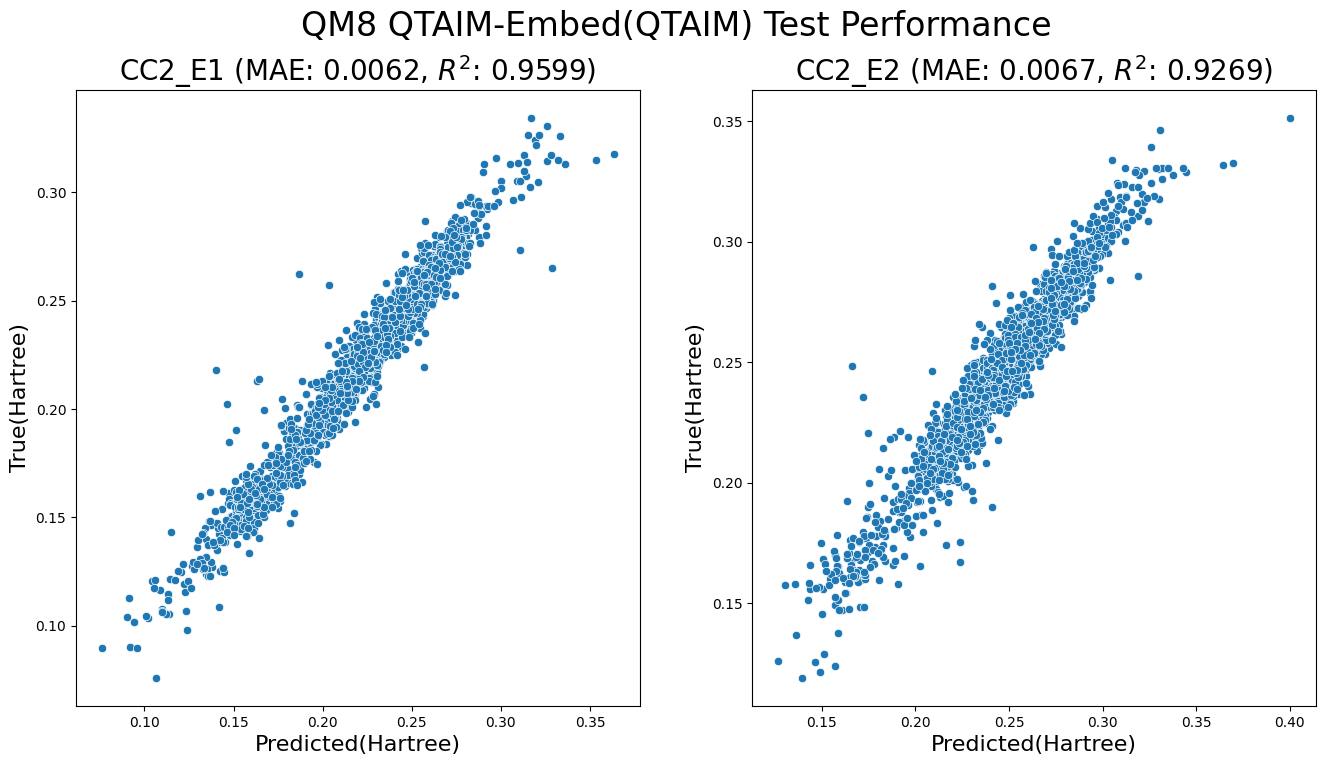

In [61]:
name_list = ["CC2_E1", "CC2_E2"]
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i in range(2):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.4f}, $R^2$: {:.4f})".format(
            key,
            mae,
            r2,
        ), fontsize=20
    )
    ax[i].set_xlabel("Predicted(Hartree)", fontsize=16)
    ax[i].set_ylabel("True(Hartree)", fontsize=16)
fig.suptitle("QM8 QTAIM-Embed(QTAIM) Test Performance", fontsize=24)
save_string = os.path.join(
    "./test_performance_{}_{}.png".format("qm8", "qtaim")
)
fig.savefig(save_string, dpi=300)
fig.show()

In [12]:
model_temp = load_graph_level_model_from_config(best_model_noqtaim)

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_train_qtaim_small, batch_size=256, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_test_qtaim_small,
    batch_size=len(dataset_test_qtaim_small.graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=100, verbose=False, mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=1.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)


trainer.fit(model_temp, dataloader_train)
trainer.save_checkpoint(f"./qm8_manual_noqtaim.ckpt")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params
---------------------------------------------------------
0  | activation      | ReLU                | 0     
1  | embedding       | UnifySize           | 352   
2  | conv_layers     | ModuleList          | 8.2 K 
3  | readout         | WeightAndSumThenCat | 34    
4  | loss            | ModuleList          | 0     
5  | fc_layers       | ModuleList          | 2.2 M 
6  | train_r2        | MultioutputWrapper  | 0     
7  | train_torch_l1  | Multi

:::REGRESSION MODEL:::
readout in size 48
... > number of tasks: 2


/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 6.7822e-03.
Epoch 00053: reducing learning rate of group 0 to 3.3911e-03.
Epoch 00079: reducing learning rate of group 0 to 1.6956e-03.


In [24]:
model_temp = load_graph_level_model_from_config(
    {"restore": True, "restore_path": "./qm8_manual_noqtaim.ckpt"}
)

:::RESTORING MODEL FROM EXISTING FILE:::
readout in size 48
... > number of tasks: 2
:::MODEL LOADED:::


In [25]:
import seaborn as sns

model_temp.cpu()
batch_graph, batched_labels = next(iter(dataloader_test))
r2_pre, mae, mse, preds_unscaled, labels_unscaled = model_temp.evaluate_manually(
    batch_graph,
    batched_labels,
    scaler_list=dataset_train_qtaim_small.label_scalers,
)


print("r2", r2_pre)
print("mae", mae)
print("mse", mse)


r2 tensor([0.8226, 0.7472])
mae tensor([0.0131, 0.0128])
mse tensor([0.0185, 0.0174])


/tmp/ipykernel_8857/3382657368.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


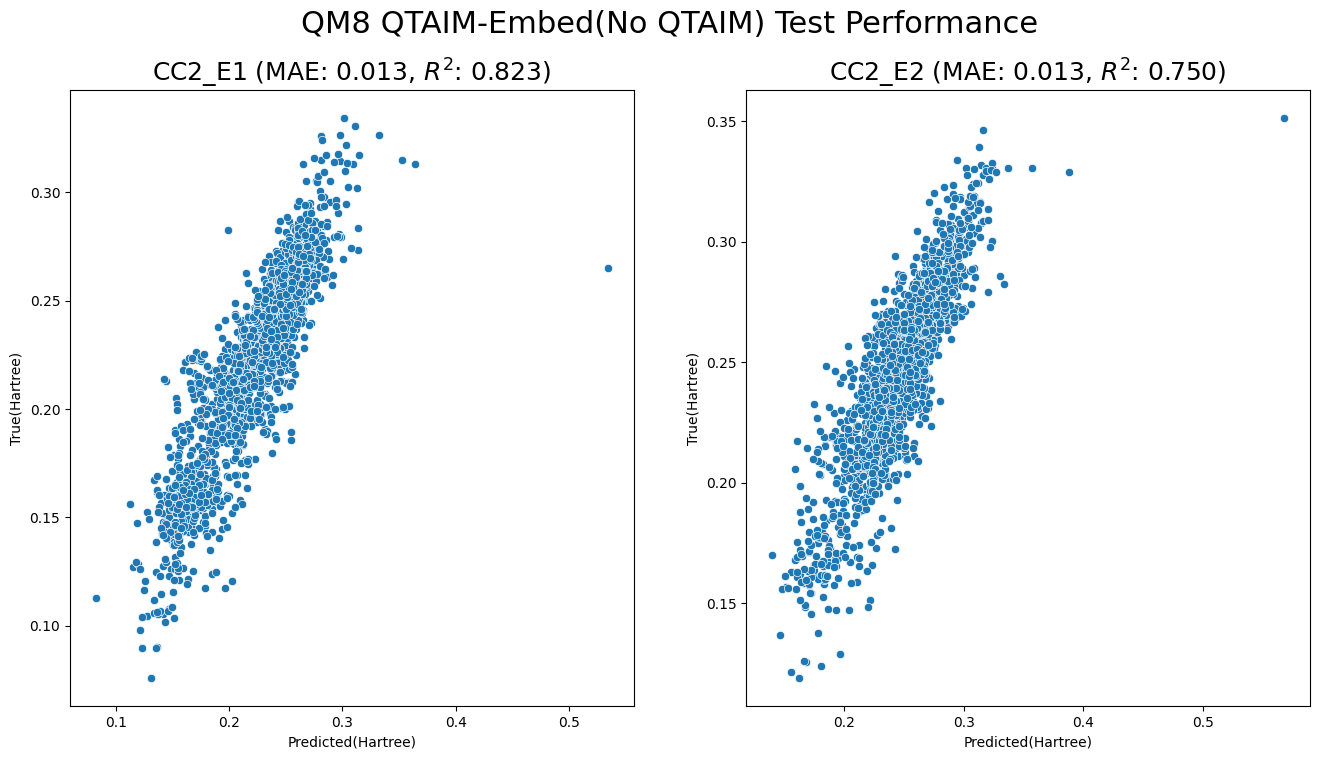

In [29]:
name_list = ["CC2_E1", "CC2_E2"]
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i in range(2):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.3f}, $R^2$: {:.3f})".format(
            key,
            mae,
            r2,
        ), fontsize=18
    )
    ax[i].set_xlabel("Predicted(Hartree)")
    ax[i].set_ylabel("True(Hartree)")
fig.suptitle("QM8 QTAIM-Embed(No QTAIM) Test Performance", fontsize=22)
save_string = os.path.join(
    "./test_performance_{}_{}.png".format("qm8", "no_qtaim")
)
fig.savefig(save_string, dpi=300)
fig.show()